In [2]:
from MLForecastPipeline import *

2025-03-31 14:45:44,252	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-03-31 14:45:44,396	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:
selected_sensors_df = pd.read_csv("../data/selected_sensors2_cleaned.csv", index_col=0)

scenarios_sensors = {
    # 0: 1, 4372603
    # "0_12M_train_7M_test": {"train_start": "2017-03-25", "train_end": "2018-03-25", "test_start": "2018-03-26", "test_end": "2018-10-10"},
    '2': {
        "26M_train":  {"train_start": "2017-04-01", "train_end": "2019-06-01"},
        "24M_train":  {"train_start": "2017-04-01", "train_end": "2019-04-01"},
        "22M_train":  {"train_start": "2017-04-01", "train_end": "2019-02-01"},
        "20M_train":  {"train_start": "2017-04-01", "train_end": "2018-12-01"},
        "18M_train":  {"train_start": "2017-04-01", "train_end": "2018-10-01"},
        "12M_train":  {"train_start": "2017-04-01", "train_end": "2018-04-01"},
        "10M_train":  {"train_start": "2017-04-01", "train_end": "2018-01-25"},
        "8M_train":   {"train_start": "2017-04-01", "train_end": "2017-10-25"},
        
        # Non-Heating Periods
        "NH_3M_train":  {"train_start": "2017-04-15", "train_end": "2017-07-15"},
        "NH_4M_train":  {"train_start": "2017-04-15", "train_end": "2017-08-15"},
        "NH_2M_train":  {"train_start": "2017-04-15", "train_end": "2017-06-15"},
        "NH_1M_train":  {"train_start": "2017-04-15", "train_end": "2017-05-15"},
        "NH_15D_train": {"train_start": "2017-04-15", "train_end": "2017-04-30"},
        "NH_feb_2M_train": {"train_start": "2017-02-15", "train_end": "2017-04-15"},
        "NH_feb_1M_train": {"train_start": "2017-02-15", "train_end": "2017-04-15"},
        "NH_mar_2M_train": {"train_start": "2017-03-15", "train_end": "2017-05-15"},
        "NH_mar_1M_train": {"train_start": "2017-03-15", "train_end": "2017-04-15"},

        # Heating Periods
        "H_5M_train":     {"train_start": "2017-06-01", "train_end": "2017-11-01"},
        "H_3M_jul_train": {"train_start": "2017-07-01", "train_end": "2017-10-10"},
        "H_3M_sep_train": {"train_start": "2017-09-01", "train_end": "2017-12-10"},
        "H_3M_nov_train": {"train_start": "2017-11-01", "train_end": "2018-02-10"},
        },
}
scenarios_sensors['5'] = scenarios_sensors['2'].copy()
scenarios_sensors['6'] = scenarios_sensors['2'].copy()

def split_data(df, scenario, date_col="ds"):
    """Extracts train and test data based on train end date."""
    train_data = df[df[date_col] <= scenario['train_end']]
    test_start = pd.to_datetime(scenario['train_end']) + pd.Timedelta(days=1)
    test_data = df[df[date_col] >= test_start]
    return train_data, test_data

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

LAG_TRANSFORMS_MAP = {
    "expanding_mean_rolling_14_rolling_30": {1: 'expanding_mean', 7: 'expanding_mean', 30: 'rolling_mean_30'},
    "expanding_mean_rolling_14": {1: 'expanding_mean', 7: 'rolling_mean_14', 30: 'expanding_mean'},
    "rolling_14_rolling_30_expanding": {1: 'rolling_mean_14', 7: 'rolling_mean_30', 30: 'expanding_mean'},
    "rolling_14_expanding": {1: 'rolling_mean_14', 30: 'expanding_mean'},
    "rolling_14_only": {1: 'rolling_mean_14'},
    "no_transform": {},
}

def map_lag_transforms(lag_transform_dict, lag_transforms_map=LAG_TRANSFORMS_MAP):
    for name, transform in lag_transforms_map.items():
        if lag_transform_dict == transform:
            return name
    return "unknown"

def analyze_results(df, lag_transforms_map=LAG_TRANSFORMS_MAP, mape_threshold=40, model_filter=None):
    df = df.copy()
    df['Lag Transform Name'] = df['Lag Transforms'].apply(lambda x: map_lag_transforms(x, lag_transforms_map))
    df['Lag_Set_Name'] = df['Lag Name']
    # Identify MAPE columns dynamically
    mape_columns = [col for col in df.columns if col.startswith("test_") and col.endswith("_days")]
    
    # Compute mean MAPE across all test periods
    df['MAPE'] = df[mape_columns].mean(axis=1)
    
    # Apply filtering
    top_df = df[df["MAPE"] < mape_threshold].copy()
    if model_filter:
        top_df = top_df[top_df['Model'] == model_filter].copy()
    
    # Compute groupings
    top_models = top_df.groupby("Model")["MAPE"].mean().sort_values().reset_index()
    top_transforms = top_df.groupby("Transforms")["MAPE"].mean().sort_values().reset_index()
    top_lag_transforms = top_df.groupby("Lag Transform Name")["MAPE"].mean().sort_values().reset_index()
    top_lags = top_df.groupby("Lag_Set_Name")["MAPE"].mean().sort_values().reset_index()
    
    # Compute MAPE trends over different forecasting horizons
    mape_trends = top_df.groupby("Model")[mape_columns].mean().reset_index()
    
    return top_models, top_transforms, top_lag_transforms, top_lags, mape_trends

def plot_results(top_models, top_transforms, top_lag_transforms, top_lags, mape_trends):
    plt.figure(figsize=(12, 5))
    sns.barplot(x=top_models["Model"], y=top_models["MAPE"], palette="viridis", hue=top_models["Model"])
    plt.xticks(rotation=45)
    plt.title("Average MAPE per Model")
    plt.show()

    plt.figure(figsize=(12, 5))
    sns.barplot(x=top_transforms["Transforms"], y=top_transforms["MAPE"], palette="coolwarm", hue=top_transforms["Transforms"])
    plt.xticks(rotation=90)
    plt.title("Average MAPE per Transform")
    plt.show()

    plt.figure(figsize=(12, 5))
    sns.barplot(x=top_lag_transforms["Lag Transform Name"], y=top_lag_transforms["MAPE"], palette="Blues", hue=top_lag_transforms["Lag Transform Name"])
    plt.xticks(rotation=90)
    plt.title("Average MAPE per Lag Transform")
    plt.show()

    plt.figure(figsize=(12, 5))
    sns.barplot(x=top_lags["Lag_Set_Name"], y=top_lags["MAPE"], palette="Blues", hue=top_lags["Lag_Set_Name"])
    plt.xticks(rotation=90)
    plt.title("MAPE vs Number of Lags")
    plt.show()
    
    # Plot MAPE trends across different forecasting horizons
    plt.figure(figsize=(12, 5))
    for model in mape_trends["Model"]:
        plt.plot(mape_trends.columns[1:], mape_trends[mape_trends["Model"] == model].values[0][1:], label=model)
    plt.xlabel("Forecasting Horizon (Days)")
    plt.ylabel("MAPE")
    plt.title("MAPE Trends Across Forecast Horizons")
    plt.legend()
    plt.show()

# Example usage:
# top_models, top_transforms, top_lag_transforms, top_lags, mape_trends = analyze_results(df, lag_transforms_map, optimal_lags_map)
# plot_results(top_models, top_transforms, top_lag_transforms, top_lags, mape_trends)


In [5]:
import glob
results = {}
for file in glob.glob("results/run_7/*.csv"):
    dataset_name = file.split("\\")[-1].replace(".csv", "")
    results[dataset_name] = pd.read_csv(file)

In [6]:
import re

def extract_train_info(dataset_name):
    """
    Extracts sensor ID, training length in months, and a standardized train label.
    
    Example Inputs:
        - "6_NH_15D_train"  → (6, 0.5, "NH_15D_train")
        - "6_H_5M_train"    → (6, 5, "H_5M_train")
        - "2_18M_train"     → (2, 18, "18M_train")
    
    Returns:
        - sensor (int): Sensor ID
        - train_months (float): Training length in months
        - train_label (str): Everything after the sensor ID (used for finding comparable datasets)
    """
    name_parts = dataset_name.split('_')

    # Extract sensor ID
    sensor = int(name_parts[0])  # First part is always the sensor number

    # Reconstruct the label for easy dataset comparison
    train_label = '_'.join(name_parts[1:])

    # Extract training length (2nd to last part contains number + unit)
    train_info = name_parts[-2]  # Example: "15D" or "5M"
    match = re.match(r"(\d+)([MD])", train_info)  # Extract number and unit

    if match:
        train_length = int(match.group(1))
        unit = match.group(2)

        # Convert days to months (approximate)
        train_months = train_length / 30 if unit == "D" else train_length
    else:
        return None, None, None  # Invalid format, return None values

    return sensor, train_months, train_label

In [7]:
import re
import pandas as pd
import numpy as np
from numba import njit
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean

@njit
def rolling_mean_14(x):
    return rolling_mean(x, window_size=14)

@njit
def rolling_mean_30(x):
    return rolling_mean(x, window_size=30)

# Define function mapping
lag_transforms_mapping = {
    'expanding_mean': expanding_mean,
    'rolling_mean_14': rolling_mean_14,
    'rolling_mean_30': rolling_mean_30,
}

# Function to convert lag_transforms dictionary to a string
def stringify_lag_transforms(lag_transforms):
    """Converts lag_transforms dictionary to a clean string format for storage."""
    return str({key: [func.__name__ for func in funcs] for key, funcs in lag_transforms.items()})

# Function to parse lag_transforms safely from an invalid dictionary-like string
def parse_lag_transforms(lag_transforms_str):
    """Parses a raw function dictionary string and converts it back to a proper dictionary with function references."""
    try:
        # Extract function names using regex pattern: `<function function_name at 0x...>`
        cleaned_str = re.sub(r'<function (\w+) at 0x[0-9A-Fa-f]+>', r'"\1"', lag_transforms_str)

        # Convert cleaned string into a valid Python dictionary
        temp_dict = eval(cleaned_str)  # Evaluates after function names are fixed

        # Map function names back to actual function references
        return {key: [lag_transforms_mapping[func_name] for func_name in funcs] for key, funcs in temp_dict.items()}
    
    except Exception as e:
        print(f"Error parsing lag_transforms {lag_transforms_str}: {e}")
        return {}

In [8]:
import pandas as pd
import numpy as np
import re
from numba import njit
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean
from mlforecast import MLForecast
# from my_custom_utils import format_df_to_mlforecast, split_data  # Assuming these are in a module
import ast

# Define parameters
HORIZONS = [30, 60, 90, 120, 150, 180, 240, 300, 360, 480, 600, 720, 737]
MAPE_COLUMNS = [f"test_{h}_days" for h in HORIZONS]

# Thresholds for different filtering criteria
EARLY_HORIZON_THRESHOLD = 30  # MAPE threshold for early horizons
ONE_THIRD_THRESHOLD = 30       # Threshold for MAPE at 1/3 of training length
ONE_THIRD_THRESHOLD_GENERAL = 35       # Threshold for MAPE at 1/3 of training length


EARLY_HORIZONS = [30, 60, 90, 120]  # Horizons we check for early filtering
SENSORS_TO_COMPARE = [2, 5, 6]  # Sensors that share training length criteria

# Define available lag transforms
lag_transforms_options = [
    {1: [expanding_mean], 7: [rolling_mean], 30: [expanding_mean]},
    {1: [rolling_mean], 7: [rolling_mean], 30: [expanding_mean]},
]

model_mapping = {
    "XGBRegressor": XGBRegressor(),
    "SGDRegressor": SGDRegressor(random_state=42),
    "Ridge": Ridge(),
    "Lasso": Lasso()
}

transform_mapping = {
    "AutoDifferences" : AutoDifferences, 
    "AutoSeasonalDifferences" : AutoSeasonalDifferences, 
    "AutoSeasonalityAndDifferences" : AutoSeasonalityAndDifferences,
    "LocalStandardScaler" : LocalStandardScaler, 
    "LocalMinMaxScaler" : LocalMinMaxScaler, 
    "LocalBoxCox" : LocalBoxCox
}

@njit
def rolling_mean_14(x):
    return rolling_mean(x, window_size=14)

@njit
def rolling_mean_30(x):
    return rolling_mean(x, window_size=30)

# Function to extract sensor ID and train length
def extract_train_info(dataset_name):
    name_parts = dataset_name.split('_')
    sensor = int(name_parts[0])  
    train_label = '_'.join(name_parts[1:])

    train_info = name_parts[-2]  
    match = re.match(r"(\d+)([MD])", train_info)  

    if match:
        train_length = int(match.group(1))
        unit = match.group(2)
        train_months = train_length / 30 if unit == "D" else train_length
    else:
        return None, None, None  

    return sensor, train_months, train_label

# Function to reverse `stringify_transform`
def parse_transform_string(transform_str):
    transform_str = transform_str.strip()
    if "(" in transform_str:
        class_name, params = transform_str.split("(", 1)
        params = params.rstrip(")")
        param_dict = {}
        if params != "NoParams" and class_name != "LocalBoxCox":
            for param in params.split(", "):
                key, value = param.split("=")
                if key in ("max_diffs", "season_length", "max_season_length"):
                    param_dict[key] = int(value) if value.replace(".", "").isdigit() else value
        return class_name, param_dict
    return transform_str, {}

In [9]:
# Define patterns to match and their correct format
rename_patterns = {
    "H_3M_jul_train": "H_jul_3M_train",
    "H_3M_sep_train": "H_sep_3M_train",
    "H_3M_nov_train": "H_nov_3M_train",
}

# Create a new dictionary with updated keys
updated_results = {}

for dataset_name, df in results.items():
    new_name = dataset_name  # Default: keep the same name

    for old_pattern, new_pattern in rename_patterns.items():
        if old_pattern in dataset_name:
            new_name = dataset_name.replace(old_pattern, new_pattern)
            break  # Stop checking once renamed

    updated_results[new_name] = df  # Preserve the dataset content

results = updated_results

In [10]:
import warnings
import pandas as pd

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [11]:
import hashlib
import json

def generate_model_id(model_name, transforms, lags, lag_transforms_str, dataset_name):
    """Generate a unique hash ID for a model based on its core attributes."""
    model_info = {
        "model": model_name,
        "transforms": transforms,
        "lags": lags,
        "lag_transforms": lag_transforms_str,
        "dataset": dataset_name  # Include dataset name
    }
    model_str = json.dumps(model_info, sort_keys=True)
    return hashlib.sha256(model_str.encode()).hexdigest()[:10]  # Shorten to 10 chars


In [35]:
import pandas as pd
import numpy as np
import re
import hashlib
import json

# Define parameters
HORIZONS = [30, 60, 90, 120, 150, 180, 240, 300, 360, 480, 600, 720, 737]
EARLY_HORIZON_THRESHOLD = 30
REFERENCE_EARLY_HORIZON_THR = 32.5
REFERENCE_ONE_THIRD_THR = 35
ONE_THIRD_THRESHOLD = 32
SHORT_TRAIN_FILTER = True
SHORT_TRAIN_THRESHOLD = 40

EARLY_HORIZONS = [30, 60, 90, 120]
SENSORS_TO_COMPARE = [2, 5, 6]

stored_models = {}  # Store all models globally

def generate_model_id(model_name, transforms, lags, lag_transforms, dataset_name):
    """Generate a unique hash ID based on model attributes and dataset."""
    model_info = {
        "model": model_name,
        "transforms": transforms,
        "lags": lags,
        "lag_transforms": lag_transforms,
        "dataset": dataset_name  # Ensures uniqueness across datasets
    }
    model_str = json.dumps(model_info, sort_keys=True)
    return hashlib.sha256(model_str.encode()).hexdigest()[:10]  # Short ID

for dataset_name, df in results.items():
    print("=" * 80)
    print(f"DATASET: {dataset_name}")
    print("=" * 80)

    sensor_id_main, train_months, train_label = extract_train_info(dataset_name)
    if sensor_id_main is None:
        print("Skipping dataset: Cannot determine sensor ID or train length.")
        continue

    # Extract unique sensors from column names
    sensor_pattern = re.compile(r"(\d+)_test_(\d+)_days")
    sensor_horizons = {}

    for col in df.columns:
        match = sensor_pattern.match(col)
        if match:
            sensor_id, horizon = match.groups()
            horizon = int(horizon)
            sensor_horizons.setdefault(sensor_id, []).append(horizon)

    filtered_results = {}

    for sensor_id, horizons in sensor_horizons.items():
        print(f"\nProcessing Sensor {sensor_id}...")

        short_train_mask = True
        if SHORT_TRAIN_FILTER and train_months < 12:
            short_train_mask = df[f"{sensor_id}_test_360_days"] <= SHORT_TRAIN_THRESHOLD

        sensor_mape_cols = [f"{sensor_id}_test_{h}_days" for h in sorted(horizons)]
        early_horizon_cols = [f"{sensor_id}_test_{h}_days" for h in EARLY_HORIZONS if f"{sensor_id}_test_{h}_days" in df.columns]

        if not early_horizon_cols:
            continue  # Skip if no early horizon data

        # Apply Early Horizon Filter
        mask_early_horizon = (df[early_horizon_cols] <= EARLY_HORIZON_THRESHOLD).all(axis=1)

        # One-Third Training Length Filter
        one_third_horizon = int(train_months * 30 // 3)
        closest_horizon = min(horizons, key=lambda x: abs(x - one_third_horizon))
        mask_one_third = df.get(f"{sensor_id}_test_{closest_horizon}_days", pd.Series(True)) <= ONE_THIRD_THRESHOLD

        # Reference Sensors Filtering
        reference_masks = []

        for ref_sensor in SENSORS_TO_COMPARE:
            if str(ref_sensor) == sensor_id:
                continue

            # Early horizon columns for this reference sensor
            ref_cols = [f"{ref_sensor}_test_{h}_days" for h in EARLY_HORIZONS if f"{ref_sensor}_test_{h}_days" in df.columns]
            mask_ref_early = pd.Series(True, index=df.index)
            if ref_cols:
                mask_ref_early = df[ref_cols].mean(axis=1) <= REFERENCE_EARLY_HORIZON_THR

            # One-third horizon for this reference sensor
            ref_one_third_col = None
            if str(ref_sensor) in sensor_horizons:
                ref_horizons = sensor_horizons[str(ref_sensor)]
                one_third_days = int(train_months * 30 // 3)
                closest_ref_horizon = min(ref_horizons, key=lambda x: abs(x - one_third_days))
                ref_one_third_col = f"{ref_sensor}_test_{closest_ref_horizon}_days"

            mask_ref_one_third = pd.Series(True, index=df.index)
            if ref_one_third_col in df.columns:
                mask_ref_one_third = df[ref_one_third_col] <= REFERENCE_ONE_THIRD_THR

            # Combine early and one-third checks for this reference sensor
            reference_masks.append(mask_ref_early & mask_ref_one_third)

        # Combine all reference sensor checks
        if reference_masks:
            mask_reference_sensors = reference_masks[0]
            for mask in reference_masks[1:]:
                mask_reference_sensors &= mask
        else:
            mask_reference_sensors = pd.Series(True, index=df.index)

        # Apply Filters
        df_filtered = df[mask_early_horizon & mask_reference_sensors & mask_one_third & short_train_mask].copy()
        if df_filtered.empty:
            continue

        # Compute Stability Metrics
        df_filtered[f"{sensor_id}_std_mape"] = df_filtered[sensor_mape_cols].std(axis=1)
        df_filtered[f"{sensor_id}_avg_mape"] = df_filtered[sensor_mape_cols].mean(axis=1)

        TOP_N = 5   

        # Top-N models with the lowest average MAPE (best overall performance)
        top_n_avg = df_filtered.nsmallest(TOP_N, f"{sensor_id}_avg_mape")

        # Top-N most stable models (lowest std deviation of MAPE)
        top_n_stable = df_filtered.nsmallest(TOP_N, f"{sensor_id}_std_mape")

        # Best model for each forecast horizon
        best_models = {}
        for col in sensor_mape_cols:
            if df_filtered[col].notna().sum() > 0:
                best_idx = df_filtered[col].idxmin()
                best_models[col] = df_filtered.loc[best_idx]

        # Most stable model across horizons
        best_stability_idx = df_filtered[f"{sensor_id}_std_mape"].idxmin()
        best_stability_row = df_filtered.loc[best_stability_idx]

        # Store everything
        filtered_results[sensor_id] = {
            "df_filtered": df_filtered,
            "best_models": best_models,
            "best_stability_row": best_stability_row,
            "top_n_avg": top_n_avg,
            "top_n_stable": top_n_stable,
        }


    # **Store Best Models**
    for _, sensor_results in filtered_results.items():
        for horizon, row in sensor_results["best_models"].items():
            model_name, transforms, lags, lag_transforms_str = row["Model"], row["Transforms"], row["Lags"], row["Lag Transforms"]

            model_id = generate_model_id(model_name, transforms, lags, lag_transforms_str, dataset_name)

            # Use dataset_name as top-level key (sensor_id not needed separately)
            stored_models.setdefault(dataset_name, {}).setdefault(model_id, {
                "model": model_name,
                "transforms": transforms,
                "lags": lags,
                "lag_transforms": lag_transforms_str,
                "horizons": {}
            })["horizons"][horizon] = row[horizon]  # Add horizon data

    for _, sensor_results in filtered_results.items():
        for horizon, row in sensor_results["top_n_avg"].T.items():  
            print(row)
            model_name, transforms, lags, lag_transforms_str = row["Model"], row["Transforms"], row["Lags"], row["Lag Transforms"]
            model_id = generate_model_id(model_name, transforms, lags, lag_transforms_str, dataset_name)
            stored_models.setdefault(dataset_name, {}).setdefault(model_id, {
                "model": model_name, "transforms": transforms, "lags": lags, "lag_transforms": lag_transforms_str,
            })
    for _, sensor_results in filtered_results.items():
        for horizon, row in sensor_results["top_n_stable"].T.items():  
            model_name, transforms, lags, lag_transforms_str = row["Model"], row["Transforms"], row["Lags"], row["Lag Transforms"]
            model_id = generate_model_id(model_name, transforms, lags, lag_transforms_str, dataset_name)
            stored_models.setdefault(dataset_name, {}).setdefault(model_id, {
                "model": model_name, "transforms": transforms, "lags": lags, "lag_transforms": lag_transforms_str,
            })    

DATASET: 2_10M_train

Processing Sensor 2...

Processing Sensor 5...

Processing Sensor 6...
DATASET: 2_12M_train

Processing Sensor 2...

Processing Sensor 5...

Processing Sensor 6...
Model                                                           Lasso
Transforms                             AutoDifferences(max_diffs=188)
Lags                [1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 23, 29...
Lag Transforms      {1: [<function expanding_mean at 0x000002019D6...
Lag Name                                          lags_47_features_15
2_test_30_days                                              18.393486
2_test_60_days                                              18.619939
2_test_90_days                                              19.153204
2_test_120_days                                             21.463564
2_test_150_days                                             21.444176
2_test_180_days                                             20.111707
2_test_240_days                             

In [ ]:
# **Print Stored Models**
for dataset_name, models in stored_models.items():
    print(f"\n=== Best Models for Dataset {dataset_name} ===")
    for model_id, model_info in models.items():
        print(f"ID: {model_id}")
        print(f"  Model: {model_info['model']}")
        print(f"  Transforms: {model_info['transforms']}")
        print(f"  Lags: {model_info['lags']}")
        # print(f"  Lag Transforms: {model_info['lag_transforms']}")
        if horizons in list(model_info.keys()):
            print("  MAPE per Horizon:")
            for horizon, mape in sorted(model_info["horizons"].items()):
                print(f"    {horizon} days: MAPE={mape:.2f}")
        print()


=== Best Models for Dataset 2_12M_train ===
ID: 1a6b38364a
  Model: Lasso
  Transforms: AutoDifferences(max_diffs=188)
  Lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 23, 29, 33]

ID: 5206b8dbda
  Model: Ridge
  Transforms: AutoDifferences(max_diffs=188)
  Lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 23, 29, 33]

ID: e46571ef9f
  Model: XGBRegressor
  Transforms: LocalBoxCox(lower=0.0, method=loglik, season_length=None, stats_=[[4.10226185e-05 1.83472028e+02]
 [4.10226185e-05 2.86542042e+02]
 [4.10226185e-05 2.08816756e+02]], upper=2.0)
  Lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 23, 29, 33]

ID: f1a72f2033
  Model: Ridge
  Transforms: LocalBoxCox(lower=0.0, method=loglik, season_length=None, stats_=[[4.10226185e-05 1.83472028e+02]
 [4.10226185e-05 2.86542042e+02]
 [4.10226185e-05 2.08816756e+02]], upper=2.0)
  Lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 4

In [23]:
def get_model_by_id(sensor_id, model_id):
    """Retrieve model details using sensor ID and model hash ID."""
    return stored_models.get(sensor_id, {}).get(model_id, None)

selected_model_ids = ['5308482a5d', '1b6481d847', '1a6b38364a', 
             '8ab48ac0fa', '8fcc2016f4', 
             'c54a4e855f', 'ed1d102b45', 
             ]

In [40]:
selected_model_ids = []
for dataset_name, models in stored_models.items():
    for model_id, model_info in models.items():
        selected_model_ids.append(model_id)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

def calculate_metrics(y_true, y_pred):
    """Compute MAPE and RMSE."""
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # Convert to percentage
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mape, rmse

# Convert full_date to datetime if not already
selected_sensors_df['full_date'] = pd.to_datetime(selected_sensors_df['full_date']) 

# Function to reformat dataset
def format_multi_df_to_mlforecast(df):
    df_melted = df.melt(id_vars=['full_date'], var_name='unique_id', value_name='y')
    return df_melted.rename(columns={'full_date': 'ds'})

# Iterate through stored models
metrics_results = {}

for dataset_name, models in stored_models.items():
    print(f"\nRecreating models for dataset: {dataset_name}")

    # Extract sensor_id and train_label from dataset_name
    sensor_id_main, train_months, train_label = extract_train_info(dataset_name)

    if sensor_id_main is None:
        print(f"Skipping dataset {dataset_name}: Cannot determine sensor ID or train length.")
        continue

    for model_id, model_info in models.items():
        if model_id not in selected_model_ids:
            continue
        
        print(f"\nProcessing Model ID: {model_id}")

        # Extract model components
        model_name = model_info["model"]
        transforms_str = model_info["transforms"]
        lags = model_info["lags"]
        lag_transforms_str = model_info["lag_transforms"]

        # Reconstruct transforms
        transform_objects = []
        if isinstance(transforms_str, str):
            for transform_str in transforms_str.split(" | "):
                class_name, params = parse_transform_string(transform_str)
                
                if class_name in transform_mapping:
                    transform_objects.append(transform_mapping[class_name](**params) if params else transform_mapping[class_name]())
                else:
                    raise ValueError(f"Unknown transform: {class_name}")

        # Reverse lag transforms
        lag_transforms = parse_lag_transforms(lag_transforms_str)

        # Prepare dataset
        sensor_id = str(sensor_id_main)  # Convert to string for consistency
        if sensor_id not in scenarios_sensors:
            print(f"Skipping sensor {sensor_id}: No scenario configuration found.")
            continue
        
        scenario = scenarios_sensors[sensor_id][train_label]

        # Format dataset for MLForecast
        formatted_df = format_multi_df_to_mlforecast(selected_sensors_df)
        formatted_df = formatted_df[['ds', 'y', 'unique_id']]
        
        # Split data into train and test
        train_df, test_df = split_data(formatted_df, scenario)

        # Initialize MLForecast model
        model_instance = model_mapping.get(model_name)
        if model_instance is None:
            raise ValueError(f"Model {model_name} not found in model_mapping")

        fcst = MLForecast(
            models=[model_instance],
            freq='D',
            lags=ast.literal_eval(lags),  # Convert string representation of list to actual list
            target_transforms=transform_objects,
            date_features=['dayofweek', 'month'],
            num_threads=1,
            lag_transforms=lag_transforms,
        )

        # Fit the model
        fcst.fit(train_df)

        # Generate forecasts
        unique_ids = test_df['unique_id'].unique()
        mini_test_df = test_df.loc[test_df["unique_id"] == unique_ids[0]]
        predictions = fcst.predict(h=mini_test_df.shape[0])

        # Store forecast results
        test_df_copy = test_df.copy()
        test_df_copy['forecast'] = predictions[model_name].values

        # Store metrics per unique_id
        metrics_results[model_id] = {}

        n_cols = 3  # Number of plots per row
        n_rows = int(np.ceil(len(unique_ids) / n_cols))

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4), squeeze=False)

        for i, uid in enumerate(unique_ids):
            row = i // n_cols
            col = i % n_cols
            ax = axes[row][col]

            y_true = test_df_copy[test_df_copy['unique_id'] == uid]['y'].values
            y_pred = test_df_copy[test_df_copy['unique_id'] == uid]['forecast'].values
            dates = test_df_copy[test_df_copy['unique_id'] == uid]['ds'].values

            mape, rmse = calculate_metrics(y_true, y_pred)
            metrics_results[model_id][uid] = {'MAPE': mape, 'RMSE': rmse}

            ax.plot(dates, y_true, label='Actual', marker='o')
            ax.plot(dates, y_pred, label='Predicted', linestyle='dashed', marker='x')
            ax.set_title(f"Series {uid}\nMAPE={mape:.1f}%, RMSE={rmse:.2f}")
            ax.set_xlabel("Date")
            ax.tick_params(axis='x', labelrotation=45)
            ax.set_ylabel("Value")
            ax.grid(True)
            ax.legend()

        # Hide any unused subplots
        for j in range(i + 1, n_rows * n_cols):
            fig.delaxes(axes[j // n_cols][j % n_cols])

        plt.tight_layout()
        plt.suptitle(f"Actual vs. Predicted - Sensor {sensor_id} ({model_name})", fontsize=16, y=1.02)
        plt.show()

        print(f"Model {model_name} (ID: {model_id}) trained and predicted successfully for {dataset_name}.\n")

# Print metrics per unique_id
for model_id, series_metrics in metrics_results.items():
    print(f"\n=== Metrics for Model {model_id} ===")
    for uid, metrics in series_metrics.items():
        print(f"Series {uid}: MAPE={metrics['MAPE']:.2f}%, RMSE={metrics['RMSE']:.2f}")


SyntaxError: unterminated string literal (detected at line 73) (4145177762.py, line 73)

In [73]:
models_to_keep = ['1a6b38364a', '5206b8dbda', 'c0e6df8976', '79a881c910']


Recreating models for dataset: 2_12M_train

Processing Model ID: 1a6b38364a


c:\Users\PC314\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.229e+02, tolerance: 3.715e+01
  model = cd_fast.enet_coordinate_descent(


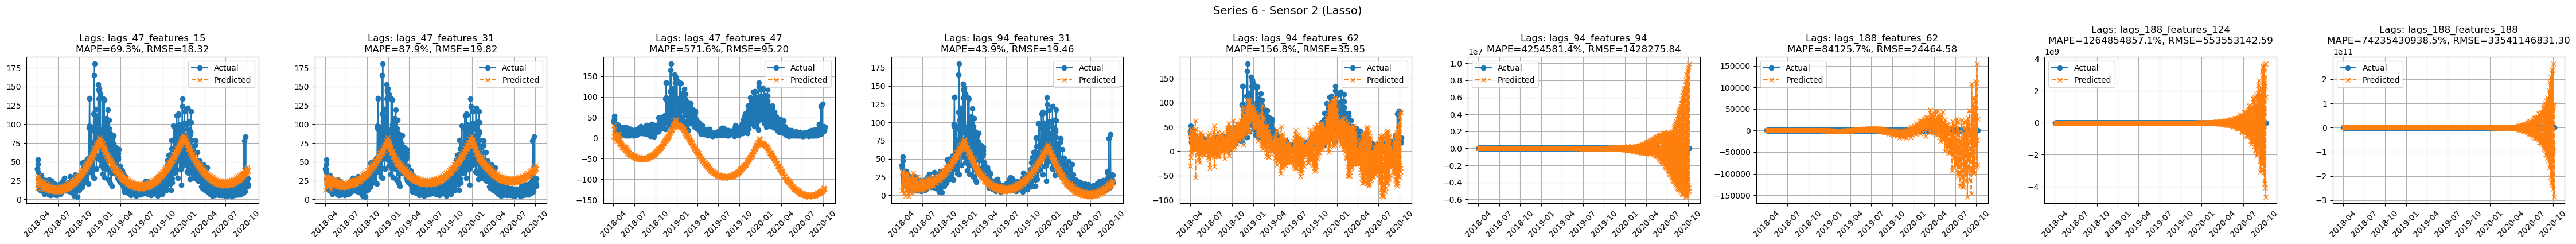


Processing Model ID: 5206b8dbda


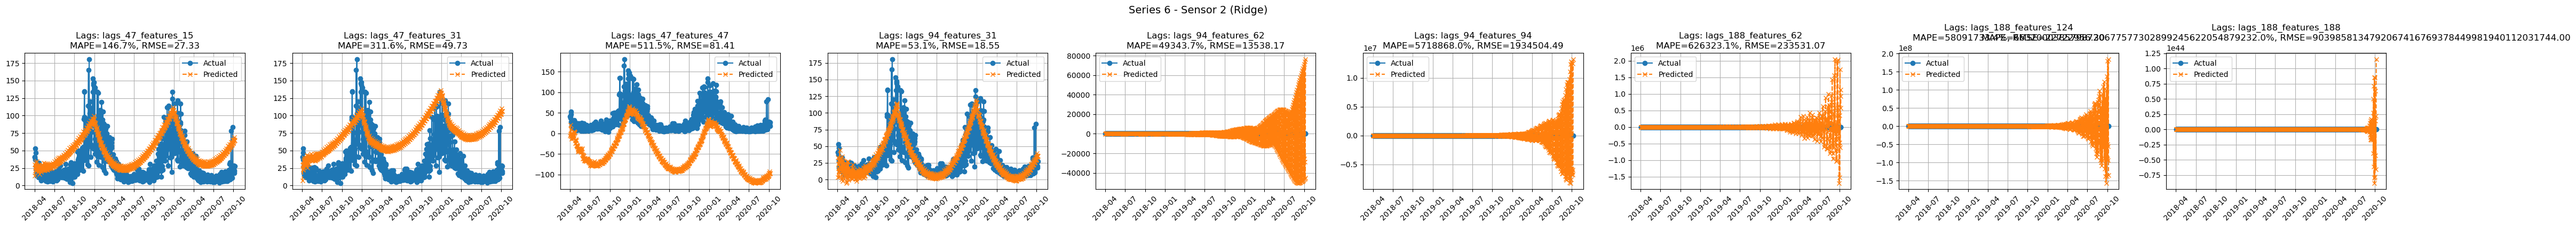


Recreating models for dataset: 5_12M_train

Processing Model ID: 79a881c910


c:\Users\PC314\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.129e+02, tolerance: 3.715e+01
  model = cd_fast.enet_coordinate_descent(


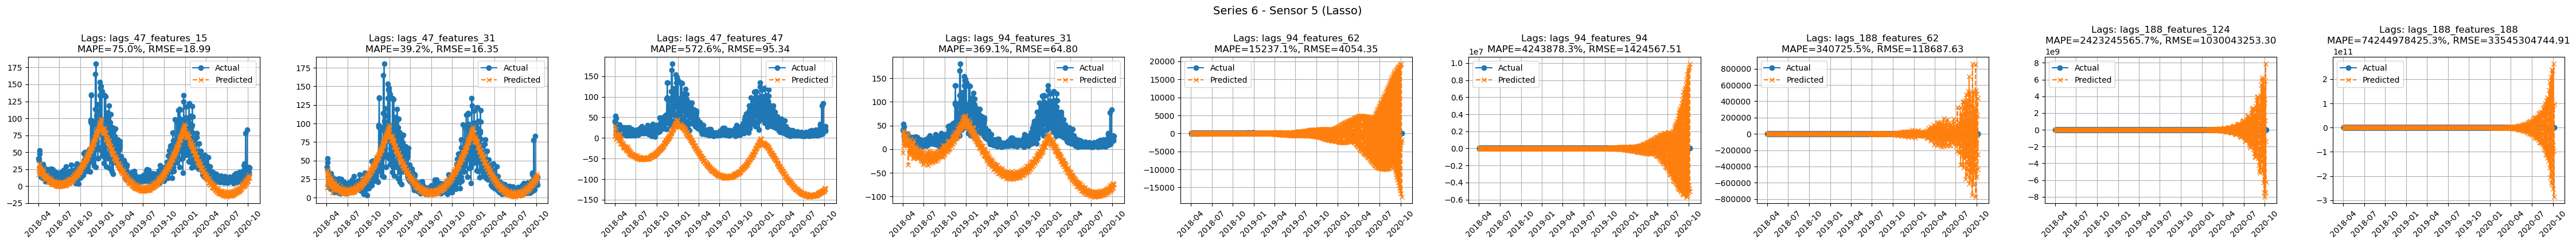


Processing Model ID: c0e6df8976


c:\Users\PC314\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.229e+02, tolerance: 3.715e+01
  model = cd_fast.enet_coordinate_descent(


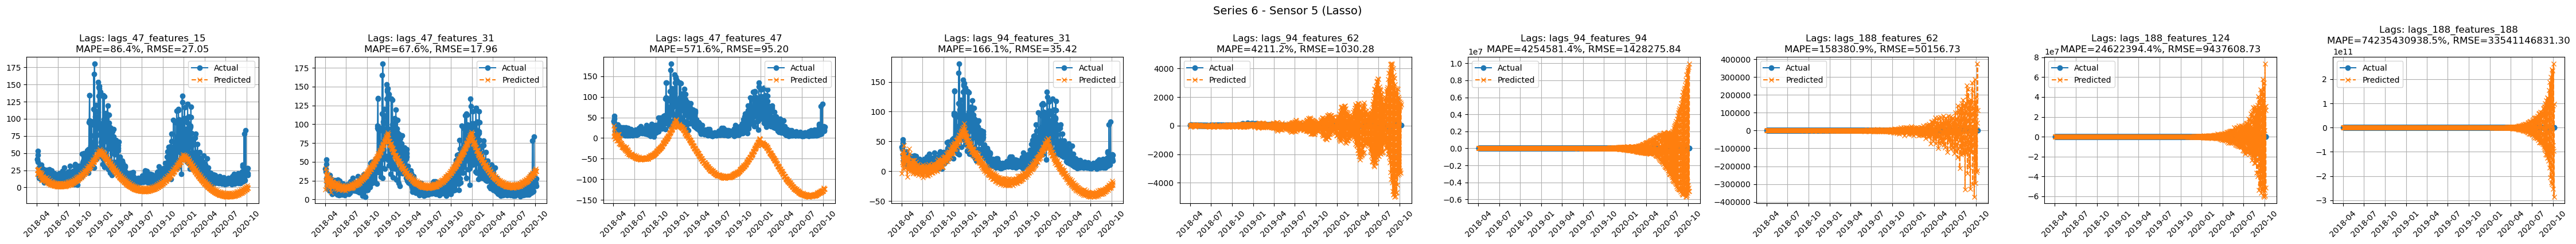


Recreating models for dataset: 6_22M_train


In [53]:
metrics_results = {}

for dataset_name, models in stored_models.items():
    print(f"\nRecreating models for dataset: {dataset_name}")

    # Extract sensor_id and train_label from dataset_name
    sensor_id_main, train_months, train_label = extract_train_info(dataset_name)

    if sensor_id_main is None:
        print(f"Skipping dataset {dataset_name}: Cannot determine sensor ID or train length.")
        continue

    for model_id, model_info in models.items():
        if model_id not in models_to_keep:
            continue
        
        print(f"\nProcessing Model ID: {model_id}")

        # Extract model components
        model_name = model_info["model"]
        transforms_str = model_info["transforms"]
        lags = model_info["lags"]
        lag_transforms_str = model_info["lag_transforms"]

        # Reconstruct transforms
        transform_objects = []
        if isinstance(transforms_str, str):
            for transform_str in transforms_str.split(" | "):
                class_name, params = parse_transform_string(transform_str)
                
                if class_name in transform_mapping:
                    transform_objects.append(transform_mapping[class_name](**params) if params else transform_mapping[class_name]())
                else:
                    raise ValueError(f"Unknown transform: {class_name}")

        # Reverse lag transforms
        lag_transforms = parse_lag_transforms(lag_transforms_str)

        # Prepare dataset
        sensor_id = str(sensor_id_main)  # Convert to string for consistency
        if sensor_id not in scenarios_sensors:
            print(f"Skipping sensor {sensor_id}: No scenario configuration found.")
            continue
        
        scenario = scenarios_sensors[sensor_id][train_label]

        # Format dataset for MLForecast
        formatted_df = format_multi_df_to_mlforecast(selected_sensors_df)
        formatted_df = formatted_df[['ds', 'y', 'unique_id']]
        
        # Split data into train and test
        train_df, test_df = split_data(formatted_df, scenario)

        model_instance = model_mapping.get(model_name)
        if model_instance is None:
            raise ValueError(f"Model {model_name} not found in model_mapping")

        for uid in formatted_df['unique_id'].unique():
            uid_train = train_df[train_df["unique_id"] == uid]
            uid_test = test_df[test_df["unique_id"] == uid]

            optimal_lags_list = get_optimal_lags(uid_train, 'y')  # Example ratios
            series_outputs = []

            for lag_name, optimal_lags in optimal_lags_list.items():
                # Initialize model with custom lags
                fcst = MLForecast(
                    models=[model_instance],
                    freq='D',
                    lags=optimal_lags,
                    target_transforms=list(transform_objects),
                    date_features=['dayofweek', 'month'],
                    num_threads=1,
                    lag_transforms=lag_transforms,
                )

                fcst.fit(uid_train[['ds', 'y', 'unique_id']])
                
                preds = fcst.predict(h=len(uid_test))
                y_pred = preds[get_sgdreg_name(model_name)].values
                y_true = uid_test['y'].values
                dates = uid_test['ds'].values

                # Compute metrics
                mape, rmse = calculate_metrics(y_true, y_pred)
                series_outputs.append({
                    "lag_name": lag_name,
                    "y_true": y_true,
                    "y_pred": y_pred,
                    "dates": dates,
                    "MAPE": mape,
                    "RMSE": rmse,
                })

        n_plots = len(series_outputs)
        fig, axs = plt.subplots(1, n_plots, figsize=(5 * n_plots, 4), squeeze=False)
        axs = axs[0]  # unpack row

        if not series_outputs:
            print(f"Skipping {uid} — no predictions to show.")
            continue
        
        for i, output in enumerate(series_outputs):
            axs[i].plot(output["dates"], output["y_true"], label="Actual", marker='o')
            axs[i].plot(output["dates"], output["y_pred"], label="Predicted", marker='x', linestyle='--')
            axs[i].set_title(f"Lags: {output['lag_name']}\nMAPE={output['MAPE']:.1f}%, RMSE={output['RMSE']:.2f}")
            axs[i].tick_params(axis='x', labelrotation=45)
            axs[i].grid(True)
            axs[i].legend()

        plt.tight_layout()
        plt.suptitle(f"Series {uid} - Sensor {sensor_id} ({model_name})", fontsize=14, y=1.05)
        plt.show()

## save models

In [57]:
import dill

with open('results_of_results/run_7/stored_models.dill', 'wb') as f:
    dill.dump(stored_models, f)

In [79]:
def get_model_from_config(model_info, sensor_id_main, train_label, scenarios_sensors, selected_sensors_df):    
    model_name = model_info["model"]
    transforms_str = model_info["transforms"]
    lags = model_info["lags"]
    lag_transforms_str = model_info["lag_transforms"]

    # Reconstruct transforms
    transform_objects = []
    if isinstance(transforms_str, str):
        for transform_str in transforms_str.split(" | "):
            class_name, params = parse_transform_string(transform_str)
            
            if class_name in transform_mapping:
                transform_objects.append(transform_mapping[class_name](**params) if params else transform_mapping[class_name]())
            else:
                raise ValueError(f"Unknown transform: {class_name}")

    # Reverse lag transforms
    lag_transforms = parse_lag_transforms(lag_transforms_str)

    # Prepare dataset
    sensor_id = str(sensor_id_main)  # Convert to string for consistency
    if sensor_id not in scenarios_sensors:
        print(f"Skipping sensor {sensor_id}: No scenario configuration found.")
        raise KeyError("0")

    scenario = scenarios_sensors[sensor_id][train_label]

    print(scenario)
    # Format dataset for MLForecast
    formatted_df = format_multi_df_to_mlforecast(selected_sensors_df)
    formatted_df = formatted_df[['ds', 'y', 'unique_id']]

    # Split data into train and test
    train_df, test_df = split_data(formatted_df, scenario)
    print(test_df.shape)

    # Initialize MLForecast model
    model_instance = model_mapping.get(model_name)
    if model_instance is None:
        raise ValueError(f"Model {model_name} not found in model_mapping")

    fcst = MLForecast(
        models=[model_instance],
        freq='D',
        lags=ast.literal_eval(lags),  # Convert string representation of list to actual list
        target_transforms=transform_objects,
        date_features=['dayofweek', 'month'],
        num_threads=1,
        lag_transforms=lag_transforms,
    )

    # Fit the model
    fcst.fit(train_df)

    # Generate forecasts
    unique_ids = test_df['unique_id'].unique()
    mini_test_df = test_df.loc[test_df["unique_id"] == unique_ids[0]]
    predictions = fcst.predict(h=mini_test_df.shape[0])

    # Store forecast results
    test_df_copy = test_df.copy()
    test_df_copy['forecast'] = predictions[model_name].values

    return fcst, test_df_copy

In [80]:
model, test_df_copy = get_model_from_config(stored_models['2_12M_train']['1a6b38364a'], '2', '12M_train', scenarios_sensors, selected_sensors_df)

with open('results_of_results/run_7/mlforecast_model.dill', 'wb') as f:
    dill.dump({'model': model, 'test_df': test_df_copy}, f)

{'train_start': '2017-04-01', 'train_end': '2018-04-01'}
(2760, 3)
